In [45]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb
import optuna
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
RANDOM_STATE = 21
torch.manual_seed(21)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Collection

Considering that music preferences have changed over the years, I assumed that the decade in which the song was released was a sign worthy of attention

In [46]:
df_60 = pd.read_csv("data/dataset-of-60s.csv")
df_60['decade_of_release'] = '60'
df_70 = pd.read_csv("data/dataset-of-70s.csv")
df_70['decade_of_release'] = '70'
df_80 = pd.read_csv("data/dataset-of-80s.csv")
df_80['decade_of_release'] = '80'
df_90 = pd.read_csv("data/dataset-of-90s.csv")
df_90['decade_of_release'] = '90'
df_00 = pd.read_csv("data/dataset-of-00s.csv")
df_00['decade_of_release'] = '0'
df_10 = pd.read_csv("data/dataset-of-10s.csv")
df_10['decade_of_release'] = '10'
df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df = df[['uri','track','artist','danceability','energy','key','loudness',
  'mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','chorus_hit','sections','decade_of_release','target']]
df

uri  \
0     spotify:track:4GiXBCUF7H6YfNQsnBRIzl   
1     spotify:track:1zyqZONW985Cs4osz9wlsu   
2     spotify:track:6cHZf7RbxXCKwEkgAZT4mY   
3     spotify:track:2IjBPp2vMeX7LggzRN3iSX   
4     spotify:track:1tF370eYXUcWwkIvaq3IGz   
...                                    ...   
5515  spotify:track:4e86fqSFhqRQk3Z9hm7XHt   
5516  spotify:track:43DFcnOZprnVlAFKwgBJ3e   
5517  spotify:track:6UPfnVoOq3y3BvapBIKs8J   
5518  spotify:track:2Ao3Wi4raEOQfKQiU9EU8y   
5519  spotify:track:3ca91BX2k7GSzEUsx1mPgI   

                                   track             artist  danceability  \
0                              Lucky Man  Montgomery Gentry         0.578   
1                         On The Hotline       Pretty Ricky         0.704   
2                     Clouds Of Dementia         Candlemass         0.162   
3               Heavy Metal, Raise Hell!      Zwartketterij         0.188   
4                        I Got A Feelin'   Billy Currington         0.630   
...                                  ...                ...           ...   
5515               (You're A) Go Nowhere       Reagan Youth         0.396   
5516                  La Fiebre de Norma       La Castañeda         0.621   
5517                          Good Times      Edie Brickell         0.562   
5518                               Inane              KMFDM         0.622   
5519  You Can Make History (Young Again)         Elton John         0.664   

      energy  key  loudness  mode  speechiness  acousticness  \
0      0.471    4    -7.270     1       0.0289      0.368000   
1      0.854   10    -5.477     0       0.1830      0.018500   
2      0.836    9    -3.009     1       0.0473      0.000111   
3      0.994    4    -3.745     1       0.1660      0.000007   
4      0.764    2    -4.353     1       0.0275      0.363000   
...      ...  ...       ...   ...          ...           ...   
5515   0.795    9    -6.070     0       0.2340      0.000928   
5516   0.655    9    -6.281     0       0.0309      0.050600   
5517   0.314   10   -15.213     0       0.0298      0.440000   
5518   0.781    7    -6.080     1       0.0368      0.000101   
5519   0.739    2    -9.005     1       0.0262      0.106000   

      instrumentalness  liveness  valence    tempo  duration_ms  \
0             0.000000    0.1590    0.532  133.061       196707   
1             0.000000    0.1480    0.688   92.988       242587   
2             0.004570    0.1740    0.300   86.964       338893   
3             0.078400    0.1920    0.333  148.440       255667   
4             0.000000    0.1250    0.631  112.098       193760   
...                ...       ...      ...      ...          ...   
5515          0.000209    0.1820    0.762  152.943        82107   
5516          0.006260    0.0937    0.690  134.167       211653   
5517          0.000011    0.1060    0.571  166.847       189827   
5518          0.755000    0.3830    0.214  120.051       330053   
5519          0.054200    0.3330    0.458   92.257       293973   

      time_signature  chorus_hit  sections decade_of_release  target  
0                  4    30.88059        13                 0       1  
1                  4    41.51106        10                 0       1  
2                  4    65.32887        13                 0       0  
3                  4    58.59528         9                 0       0  
4                  4    22.62384        10                 0       1  
...              ...         ...       ...               ...     ...  
5515               4    30.34109         6                90       0  
5516               4    34.89506        10                90       0  
5517               4    21.11763        10                90       1  
5518               4    47.13558        11                90       0  
5519               4    42.50341        14                90       1  

[41106 rows x 20 columns]

# Preprocessing

Finding the number of rows and columns

In [47]:
df.shape

(41106, 20)

searching for unique artists and track names

In [48]:
print(f'Unique artists - {len(df['artist'].unique())}\nUnique track names - {len(df['track'].unique())}')

Unique artists - 11904
Unique track names - 35860


Exploring data types and checking for nulls

In [49]:
df

uri  \
0     spotify:track:4GiXBCUF7H6YfNQsnBRIzl   
1     spotify:track:1zyqZONW985Cs4osz9wlsu   
2     spotify:track:6cHZf7RbxXCKwEkgAZT4mY   
3     spotify:track:2IjBPp2vMeX7LggzRN3iSX   
4     spotify:track:1tF370eYXUcWwkIvaq3IGz   
...                                    ...   
5515  spotify:track:4e86fqSFhqRQk3Z9hm7XHt   
5516  spotify:track:43DFcnOZprnVlAFKwgBJ3e   
5517  spotify:track:6UPfnVoOq3y3BvapBIKs8J   
5518  spotify:track:2Ao3Wi4raEOQfKQiU9EU8y   
5519  spotify:track:3ca91BX2k7GSzEUsx1mPgI   

                                   track             artist  danceability  \
0                              Lucky Man  Montgomery Gentry         0.578   
1                         On The Hotline       Pretty Ricky         0.704   
2                     Clouds Of Dementia         Candlemass         0.162   
3               Heavy Metal, Raise Hell!      Zwartketterij         0.188   
4                        I Got A Feelin'   Billy Currington         0.630   
...                                  ...                ...           ...   
5515               (You're A) Go Nowhere       Reagan Youth         0.396   
5516                  La Fiebre de Norma       La Castañeda         0.621   
5517                          Good Times      Edie Brickell         0.562   
5518                               Inane              KMFDM         0.622   
5519  You Can Make History (Young Again)         Elton John         0.664   

      energy  key  loudness  mode  speechiness  acousticness  \
0      0.471    4    -7.270     1       0.0289      0.368000   
1      0.854   10    -5.477     0       0.1830      0.018500   
2      0.836    9    -3.009     1       0.0473      0.000111   
3      0.994    4    -3.745     1       0.1660      0.000007   
4      0.764    2    -4.353     1       0.0275      0.363000   
...      ...  ...       ...   ...          ...           ...   
5515   0.795    9    -6.070     0       0.2340      0.000928   
5516   0.655    9    -6.281     0       0.0309      0.050600   
5517   0.314   10   -15.213     0       0.0298      0.440000   
5518   0.781    7    -6.080     1       0.0368      0.000101   
5519   0.739    2    -9.005     1       0.0262      0.106000   

      instrumentalness  liveness  valence    tempo  duration_ms  \
0             0.000000    0.1590    0.532  133.061       196707   
1             0.000000    0.1480    0.688   92.988       242587   
2             0.004570    0.1740    0.300   86.964       338893   
3             0.078400    0.1920    0.333  148.440       255667   
4             0.000000    0.1250    0.631  112.098       193760   
...                ...       ...      ...      ...          ...   
5515          0.000209    0.1820    0.762  152.943        82107   
5516          0.006260    0.0937    0.690  134.167       211653   
5517          0.000011    0.1060    0.571  166.847       189827   
5518          0.755000    0.3830    0.214  120.051       330053   
5519          0.054200    0.3330    0.458   92.257       293973   

      time_signature  chorus_hit  sections decade_of_release  target  
0                  4    30.88059        13                 0       1  
1                  4    41.51106        10                 0       1  
2                  4    65.32887        13                 0       0  
3                  4    58.59528         9                 0       0  
4                  4    22.62384        10                 0       1  
...              ...         ...       ...               ...     ...  
5515               4    30.34109         6                90       0  
5516               4    34.89506        10                90       0  
5517               4    21.11763        10                90       1  
5518               4    47.13558        11                90       0  
5519               4    42.50341        14                90       1  

[41106 rows x 20 columns]

Checking for nulls again. Making doubly sure

In [50]:
df.isnull().sum()

uri                  0
track                0
artist               0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
chorus_hit           0
sections             0
decade_of_release    0
target               0
dtype: int64

We can see that there are no null values in the dataset. Taking the rough statistics of the data.

In [51]:
df.describe()

danceability        energy           key      loudness          mode  \
count  41106.000000  41106.000000  41106.000000  41106.000000  41106.000000   
mean       0.539695      0.579545      5.213594    -10.221525      0.693354   
std        0.177821      0.252628      3.534977      5.311626      0.461107   
min        0.000000      0.000251      0.000000    -49.253000      0.000000   
25%        0.420000      0.396000      2.000000    -12.816000      0.000000   
50%        0.552000      0.601000      5.000000     -9.257000      1.000000   
75%        0.669000      0.787000      8.000000     -6.374250      1.000000   
max        0.988000      1.000000     11.000000      3.744000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  41106.000000  41106.000000      41106.000000  41106.000000   
mean       0.072960      0.364197          0.154416      0.201535   
std        0.086112      0.338913          0.303530      0.172959   
min        0.000000      0.000000          0.000000      0.013000   
25%        0.033700      0.039400          0.000000      0.094000   
50%        0.043400      0.258000          0.000120      0.132000   
75%        0.069800      0.676000          0.061250      0.261000   
max        0.960000      0.996000          1.000000      0.999000   

            valence         tempo   duration_ms  time_signature    chorus_hit  \
count  41106.000000  41106.000000  4.110600e+04    41106.000000  41106.000000   
mean       0.542440    119.338249  2.348776e+05        3.893689     40.106041   
std        0.267329     29.098845  1.189674e+05        0.423073     19.005515   
min        0.000000      0.000000  1.516800e+04        0.000000      0.000000   
25%        0.330000     97.397000  1.729278e+05        4.000000     27.599792   
50%        0.558000    117.565000  2.179070e+05        4.000000     35.850795   
75%        0.768000    136.494000  2.667730e+05        4.000000     47.625615   
max        0.996000    241.423000  4.170227e+06        5.000000    433.182000   

           sections        target  
count  41106.000000  41106.000000  
mean      10.475673      0.500000  
std        4.871850      0.500006  
min        0.000000      0.000000  
25%        8.000000      0.000000  
50%       10.000000      0.500000  
75%       12.000000      1.000000  
max      169.000000      1.000000

In [52]:
df['time_signature'].describe()

count    41106.000000
mean         3.893689
std          0.423073
min          0.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64

column time signature will be droped as most values are 4.

In [53]:
#Scaling the data
scale = StandardScaler()

df_X = df.drop(axis=1, labels=['time_signature','uri','target', 'track', 'artist'])


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled

danceability    energy       key  loudness      mode  speechiness  \
0          0.215416 -0.429668 -0.343315  0.555679  0.665030    -0.511673   
1          0.924004  1.086412  1.354030  0.893245 -1.503691     1.277886   
2         -2.124046  1.015160  1.071139  1.357892  0.665030    -0.297994   
3         -1.977830  1.640592 -0.343315  1.219326  0.665030     1.080465   
4          0.507849  0.730153 -0.909096  1.104859  0.665030    -0.527931   
...             ...       ...       ...       ...       ...          ...   
41101     -0.808099  0.852864  1.071139  0.781602 -1.503691     1.870147   
41102      0.457236  0.298684  1.071139  0.741877 -1.503691    -0.488447   
41103      0.125437 -1.051141  1.354030 -0.939738 -1.503691    -0.501221   
41104      0.462860  0.797446  0.505358  0.779719  0.665030    -0.419930   
41105      0.699055  0.631192 -0.909096  0.229033  0.665030    -0.543028   

       acousticness  instrumentalness  liveness   valence     tempo  \
0          0.011220         -0.508740 -0.245926 -0.039055  0.471597   
1         -1.020031         -0.508740 -0.309525  0.544503 -0.905554   
2         -1.074290         -0.493684 -0.159199 -0.906910 -1.112575   
3         -1.074596         -0.250443 -0.055127 -0.783465  1.000112   
4         -0.003533         -0.508740 -0.442506  0.331280 -0.248819   
...             ...               ...       ...       ...       ...   
41101     -1.071880         -0.508052 -0.112945  0.821319  1.154862   
41102     -0.925315         -0.488116 -0.623476  0.551984  0.509605   
41103      0.223667         -0.508704 -0.552360  0.106835  1.632688   
41104     -1.074320          1.978688  1.049193 -1.228615  0.024494   
41105     -0.761849         -0.330173  0.760104 -0.315871 -0.930675   

       duration_ms  chorus_hit  sections  decade_of_release  
0        -0.320853   -0.485415  0.518152          -1.625366  
1         0.064804    0.073928 -0.097638          -1.625366  
2         0.874330    1.327148  0.518152          -1.625366  
3         0.174751    0.972847 -0.302901          -1.625366  
4        -0.345625   -0.919860 -0.097638          -1.625366  
...            ...         ...       ...                ...  
41101    -1.284154   -0.513802 -0.918691           1.138569  
41102    -0.195220   -0.274186 -0.097638           1.138569  
41103    -0.378684   -0.999112 -0.097638           1.138569  
41104     0.800023    0.369873  0.107625           1.138569  
41105     0.496743    0.126142  0.723415           1.138569  

[41106 rows x 15 columns]

Managing outliers and creating boxplots to analyze the distribution of data and remove outliers

Text(0.5, 1.0, 'Distribution of predictors with outliers')

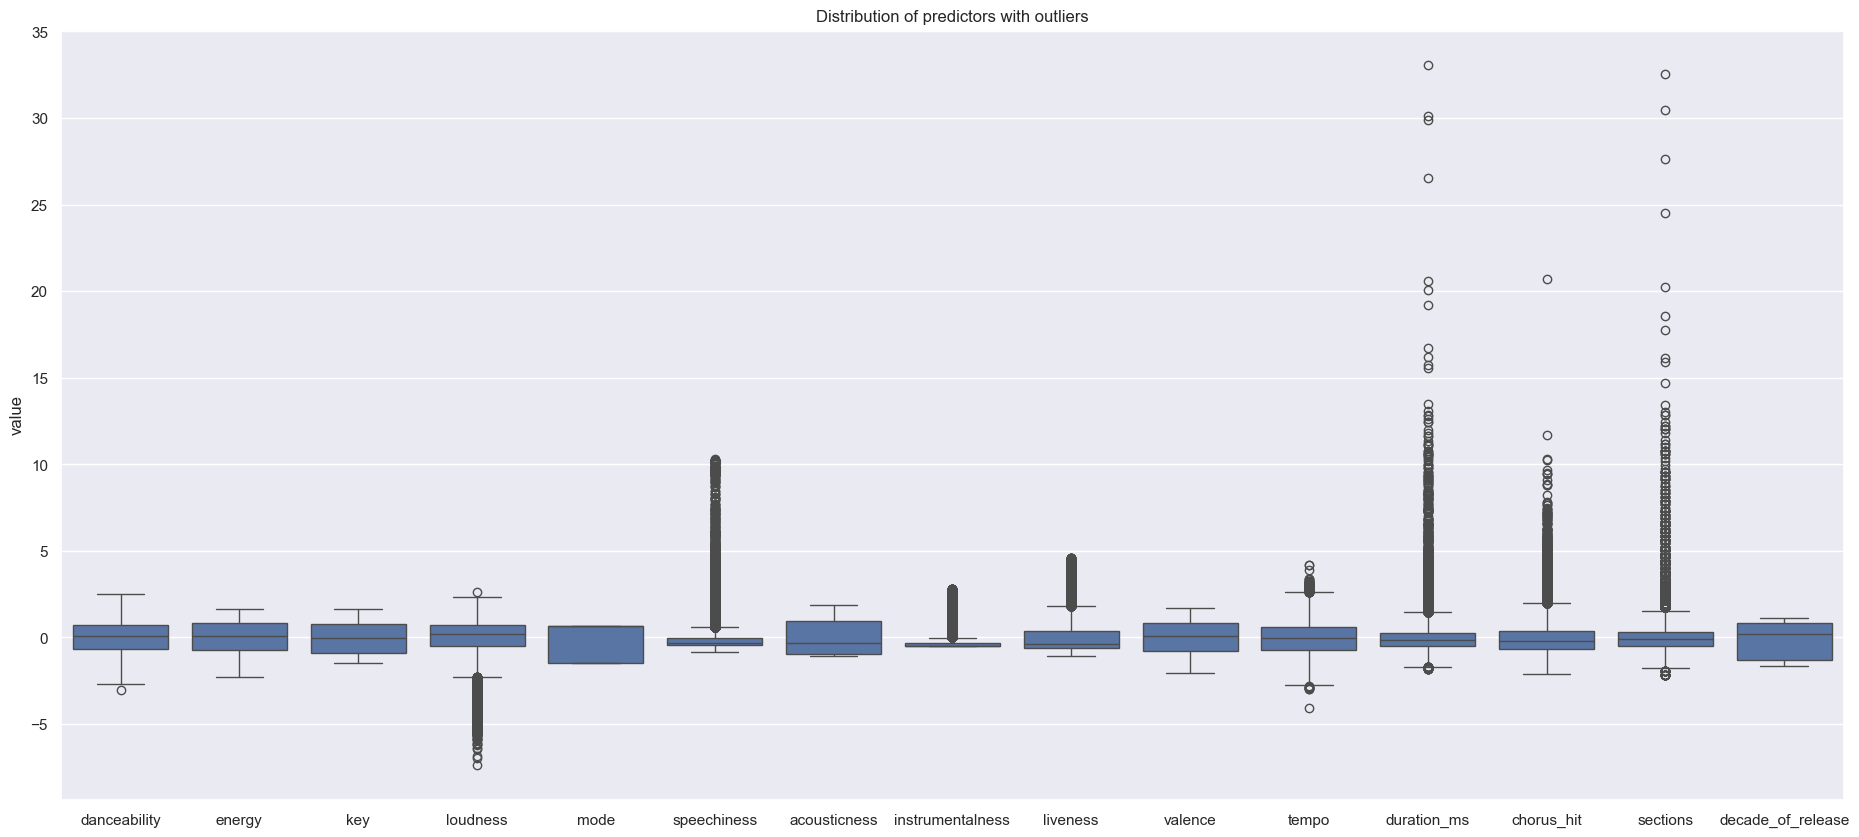

In [54]:
#box plot with outliers
df_melt=pd.melt(df_scaled)
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt)
plt.xlabel(None)
plt.title('Distribution of predictors with outliers')

Text(0.5, 1.0, 'Distribution of predictors without outliers')

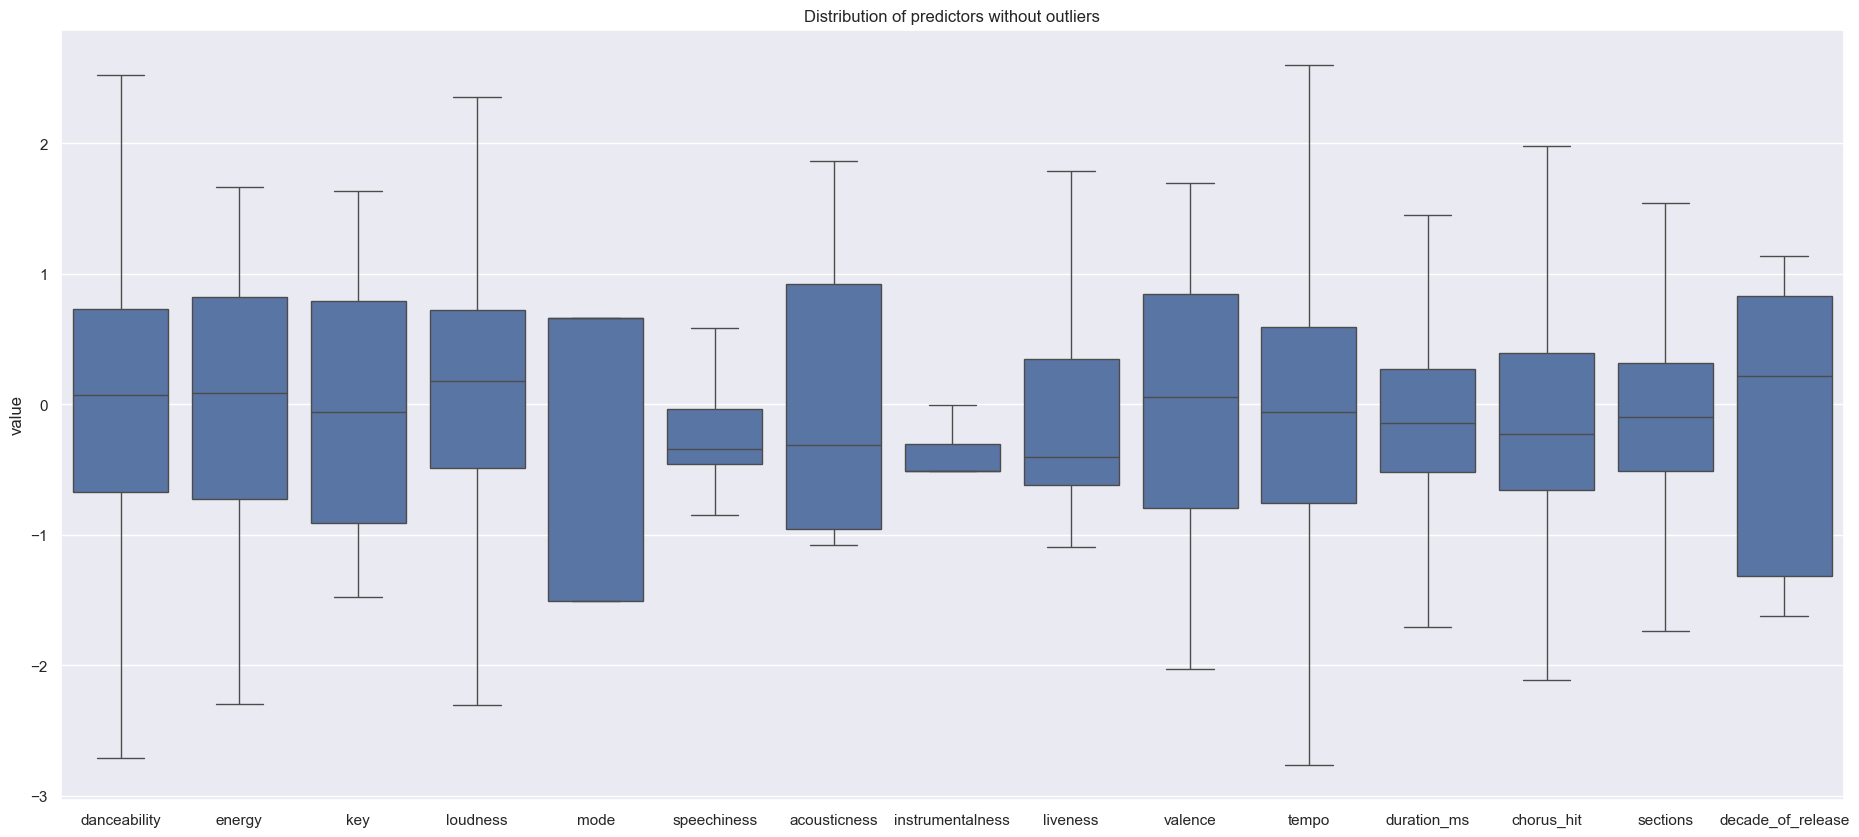

In [55]:
#boxplot without outliers
df_melt=pd.melt(df_scaled)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.xlabel(None)
plt.title('Distribution of predictors without outliers')

Removing the outliers

In [56]:
df_clean = df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]

In [57]:
#number of outliers for each predictor
df_clean.isna().sum()

danceability            1
energy                  0
key                     0
loudness             1343
mode                    0
speechiness          5088
acousticness            0
instrumentalness     8920
liveness             2688
valence                 0
tempo                 434
duration_ms          1987
chorus_hit           1839
sections             1570
decade_of_release       0
dtype: int64

Removing 2 predictors with a lot of outliers

In [58]:
#removing 2 predictors
df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [59]:
df_remove = df_clean.dropna()
df_remove.shape

(33401, 13)

Total of 33401 songs remain after cleaning

Text(0.5, 1.0, 'Distribution of predictors without outliers')

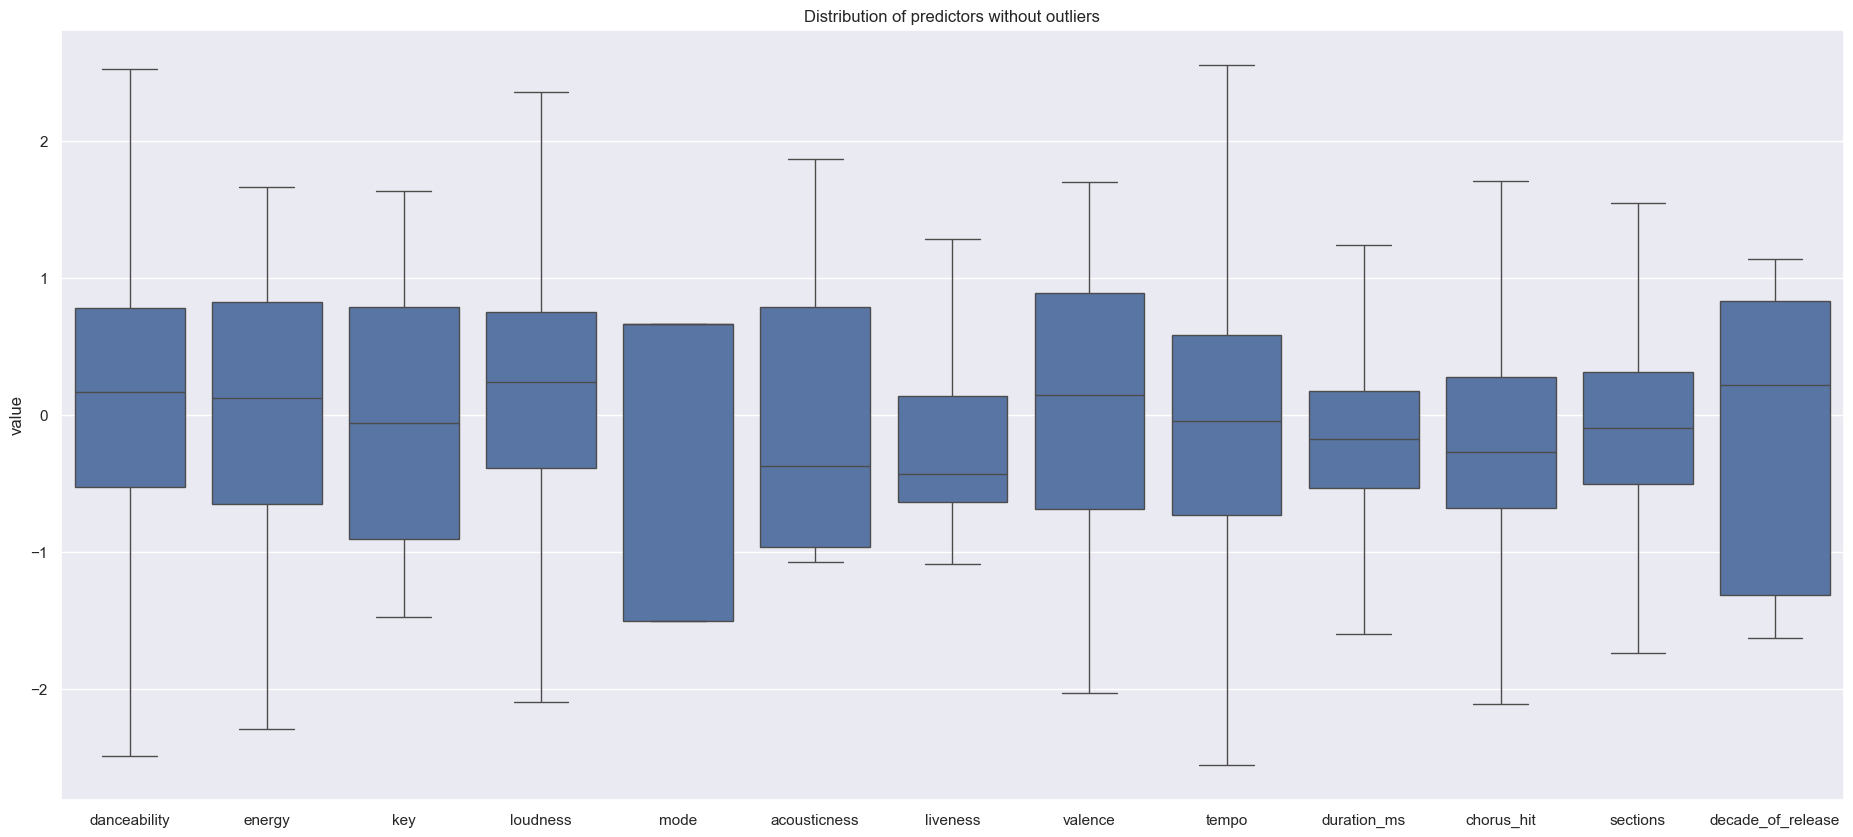

In [60]:
#box plot after removing the outliers
df_melt=pd.melt(df_remove)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.xlabel(None)
plt.title('Distribution of predictors without outliers')

Creating the unscaled dataframe without the outliers

In [61]:
df_merge = df.iloc[df_remove.index]

In [62]:
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [63]:
df_merge.columns

Index(['uri', 'track', 'artist', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'chorus_hit', 'sections', 'decade_of_release',
       'target'],
      dtype='object')

Counting the number of observations in each class

In [64]:
#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()

danceability  energy    key  loudness   mode  acousticness  liveness  \
target                                                                         
0              15247   15247  15247     15247  15247         15247     15247   
1              18154   18154  18154     18154  18154         18154     18154   

        valence  tempo  duration_ms  chorus_hit  sections  
target                                                     
0         15247  15247        15247       15247     15247  
1         18154  18154        18154       18154     18154

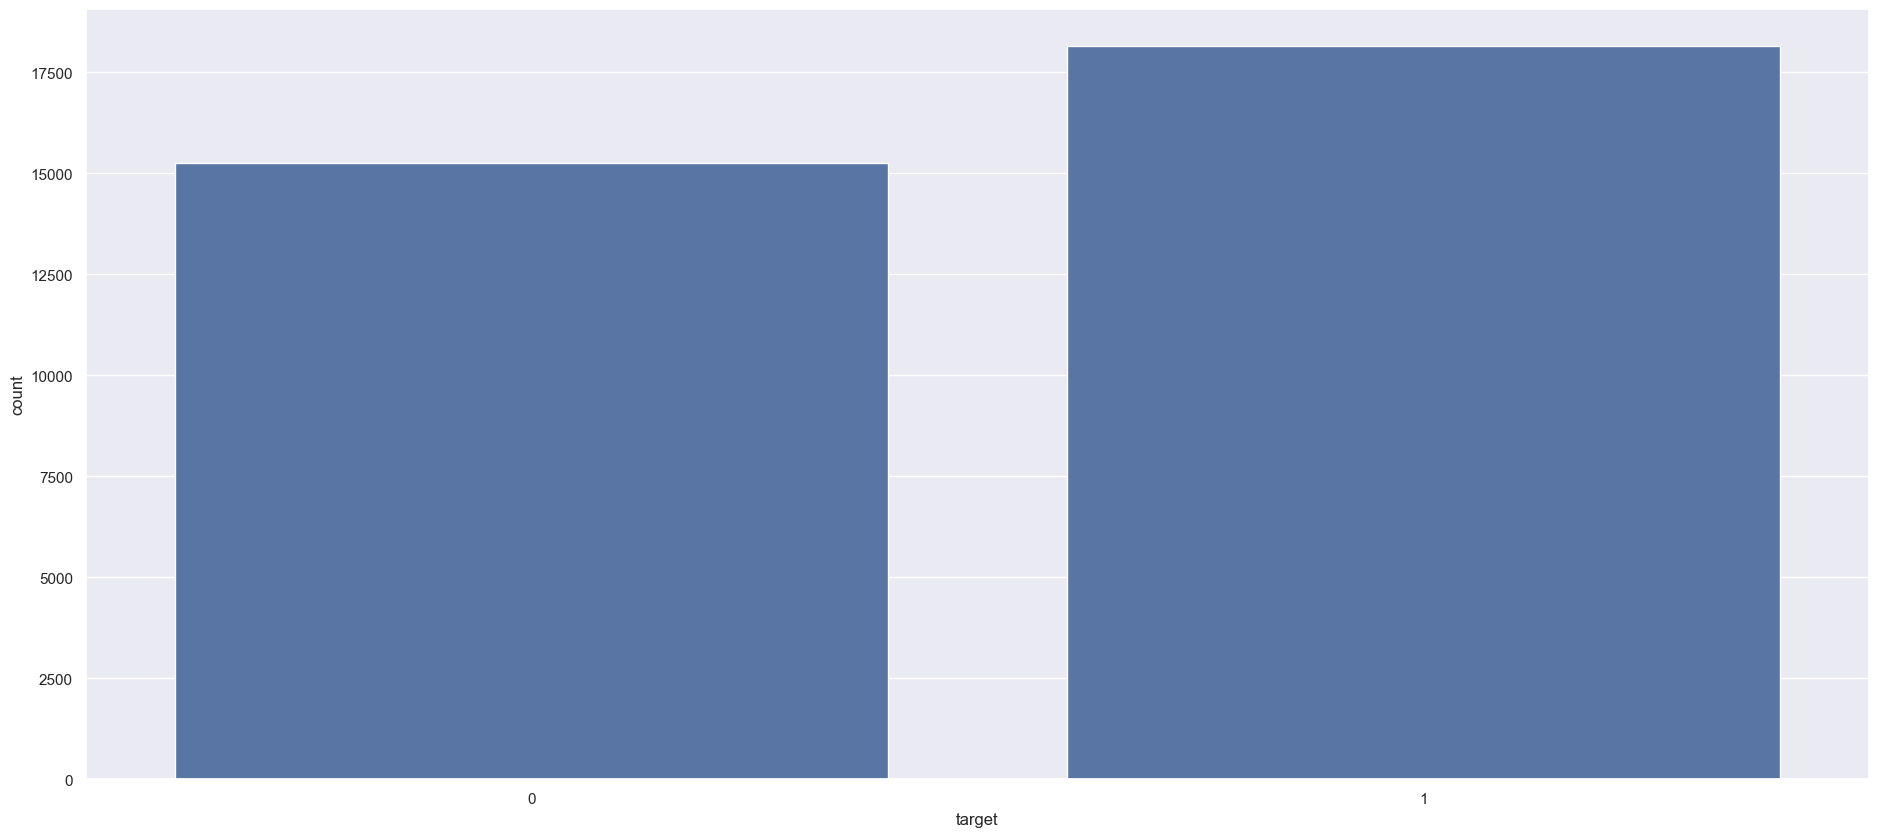

In [65]:
#plotting the number of observations
sns.countplot(x='target', data=df_merge)
sns.set_theme(rc={'figure.figsize':(12,8)})

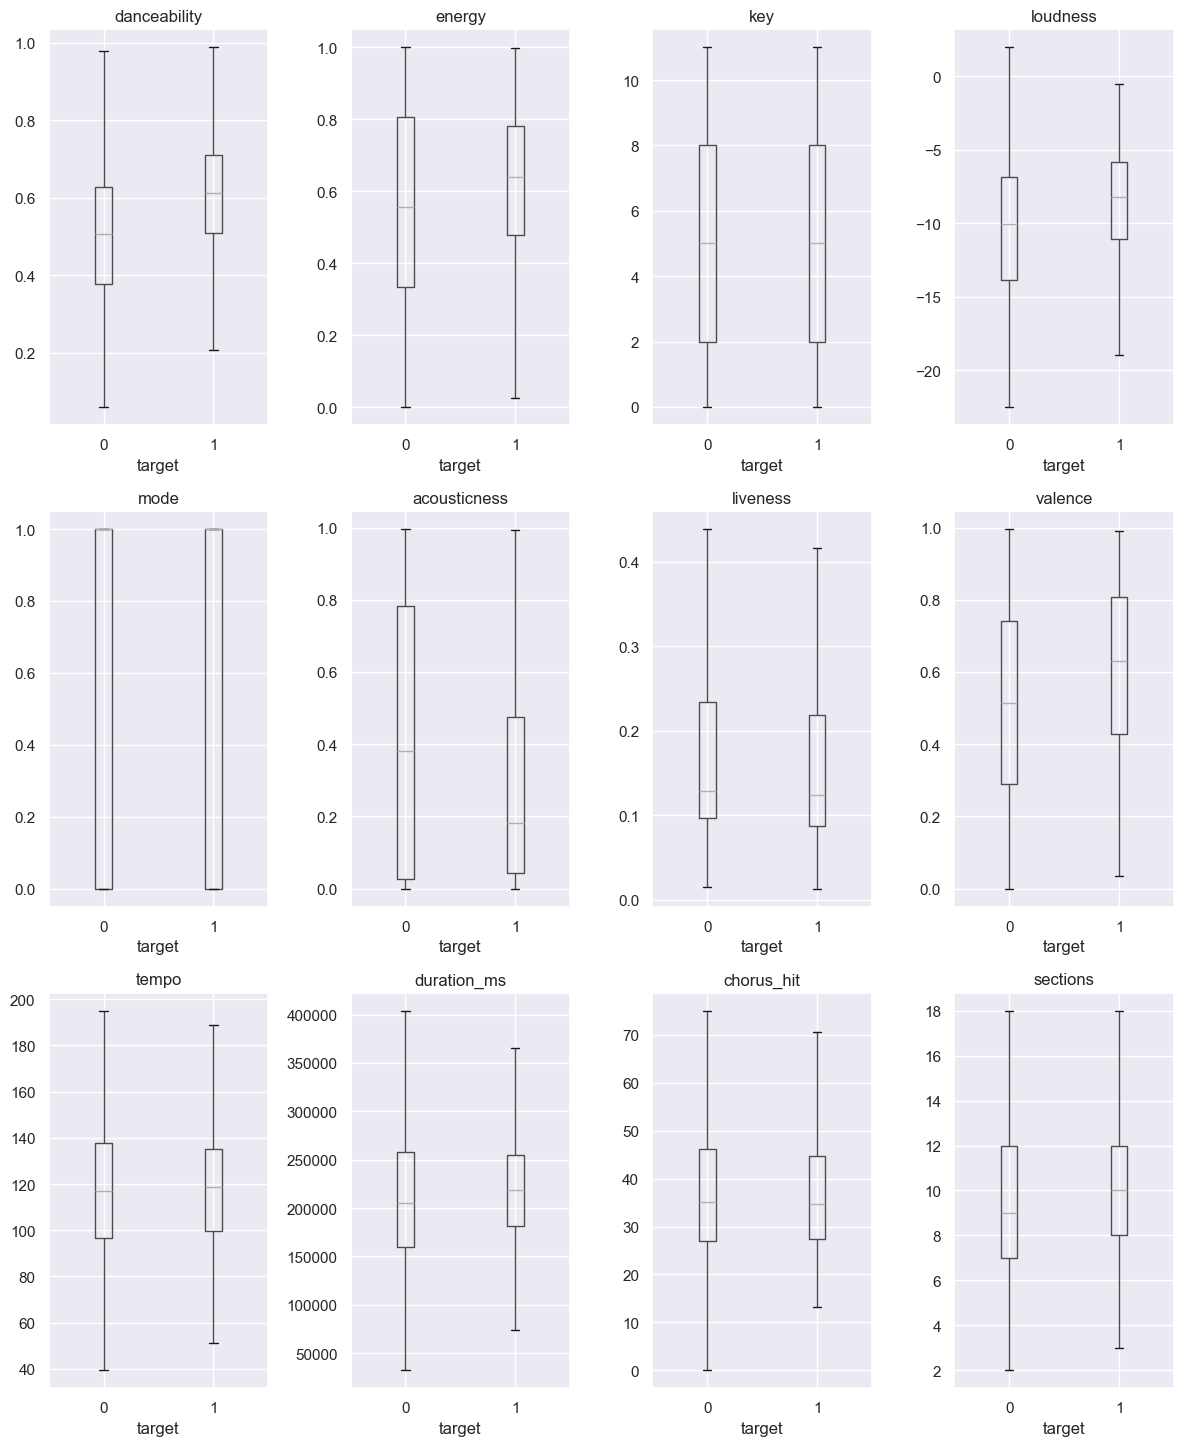

In [66]:
#plotting box plots based on target variable for different predictors
plt.rcParams["figure.figsize"] = [12, 15]
fig, axes = plt.subplots(nrows=3, ncols=4, )
df_merge.boxplot(column= 'danceability', by='target', ax=axes[0][0], showfliers=False)
df_merge.boxplot(column= 'energy', by='target', ax=axes[0][1], showfliers=False)
df_merge.boxplot(column='key', by='target', ax=axes[0][2], showfliers=False)
df_merge.boxplot(column='loudness', by='target', ax=axes[0][3], showfliers=False)
df_merge.boxplot(column='mode', by='target', ax=axes[1][0], showfliers=False)
df_merge.boxplot(column='acousticness', by='target', ax=axes[1][1], showfliers=False)
df_merge.boxplot(column='liveness', by='target', ax=axes[1][2], showfliers=False)
df_merge.boxplot(column='valence', by='target', ax=axes[1][3], showfliers=False)
df_merge.boxplot(column='tempo', by='target', ax=axes[2][0], showfliers=False)
df_merge.boxplot(column='duration_ms', by='target', ax=axes[2][1], showfliers=False)
df_merge.boxplot(column='chorus_hit', by='target', ax=axes[2][2], showfliers=False)
df_merge.boxplot(column='sections', by='target', ax=axes[2][3], showfliers=False)
plt.tight_layout()
plt.suptitle(None)
plt.show()

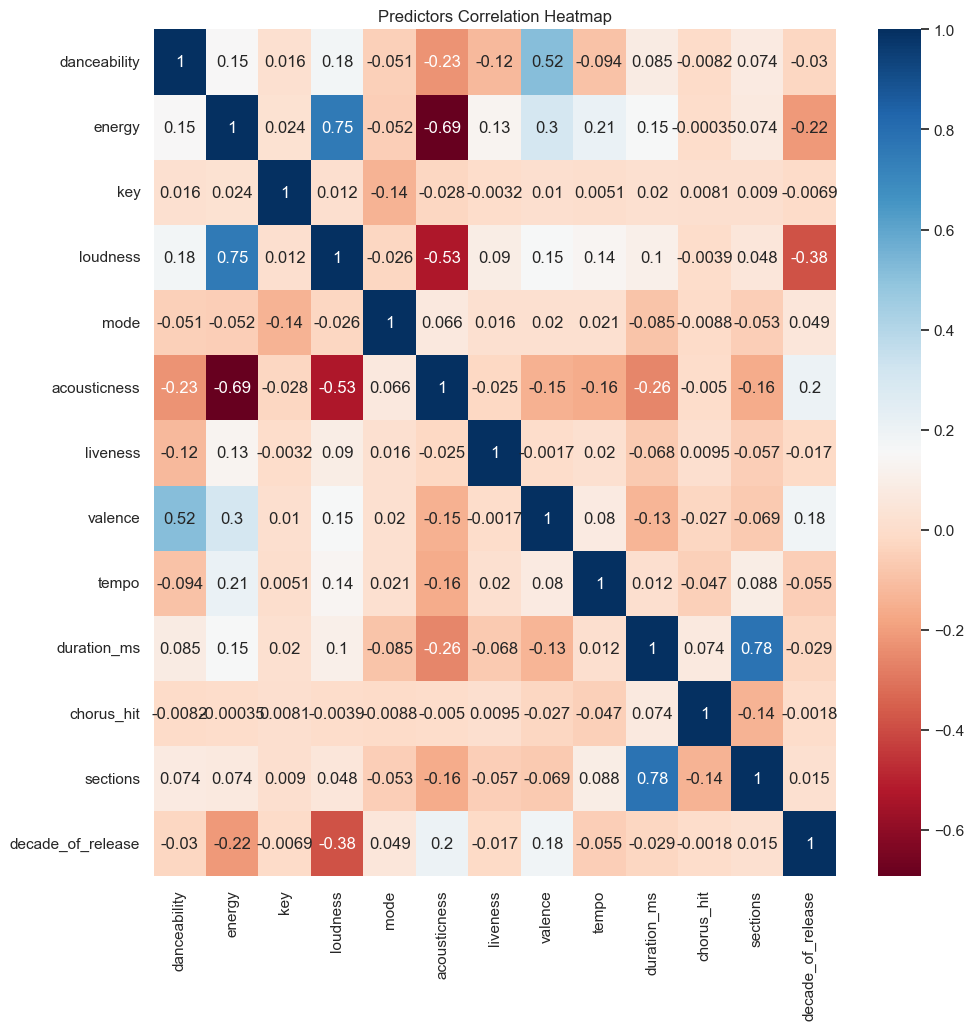

In [67]:
#correlation between the predictors
fig, ax = plt.subplots(figsize=(11,11)) 
ax = sns.heatmap(df_remove.corr(), annot=True, cmap='RdBu').set(title='Predictors Correlation Heatmap')

In [68]:
df_merge.iloc[:,3:17]

danceability  energy  key  loudness  mode  acousticness  liveness  \
0            0.578   0.471    4    -7.270     1      0.368000    0.1590   
1            0.704   0.854   10    -5.477     0      0.018500    0.1480   
2            0.162   0.836    9    -3.009     1      0.000111    0.1740   
3            0.188   0.994    4    -3.745     1      0.000007    0.1920   
4            0.630   0.764    2    -4.353     1      0.363000    0.1250   
...            ...     ...  ...       ...   ...           ...       ...   
5515         0.396   0.795    9    -6.070     0      0.000928    0.1820   
5516         0.621   0.655    9    -6.281     0      0.050600    0.0937   
5517         0.562   0.314   10   -15.213     0      0.440000    0.1060   
5518         0.622   0.781    7    -6.080     1      0.000101    0.3830   
5519         0.664   0.739    2    -9.005     1      0.106000    0.3330   

      valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
0       0.532  133.061       196707               4    30.88059        13   
1       0.688   92.988       242587               4    41.51106        10   
2       0.300   86.964       338893               4    65.32887        13   
3       0.333  148.440       255667               4    58.59528         9   
4       0.631  112.098       193760               4    22.62384        10   
...       ...      ...          ...             ...         ...       ...   
5515    0.762  152.943        82107               4    30.34109         6   
5516    0.690  134.167       211653               4    34.89506        10   
5517    0.571  166.847       189827               4    21.11763        10   
5518    0.214  120.051       330053               4    47.13558        11   
5519    0.458   92.257       293973               4    42.50341        14   

     decade_of_release  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
5515                90  
5516                90  
5517                90  
5518                90  
5519                90  

[33401 rows x 14 columns]

In [69]:
#creating final scaled data with all the variables
#scale = StandardScaler()
#scale_X = scale.fit_transform(df_merge.iloc[:,3:17])
#df_merge.iloc[:,3:17] = scale_X

In [70]:
df_merge

uri  \
0     spotify:track:4GiXBCUF7H6YfNQsnBRIzl   
1     spotify:track:1zyqZONW985Cs4osz9wlsu   
2     spotify:track:6cHZf7RbxXCKwEkgAZT4mY   
3     spotify:track:2IjBPp2vMeX7LggzRN3iSX   
4     spotify:track:1tF370eYXUcWwkIvaq3IGz   
...                                    ...   
5515  spotify:track:4e86fqSFhqRQk3Z9hm7XHt   
5516  spotify:track:43DFcnOZprnVlAFKwgBJ3e   
5517  spotify:track:6UPfnVoOq3y3BvapBIKs8J   
5518  spotify:track:2Ao3Wi4raEOQfKQiU9EU8y   
5519  spotify:track:3ca91BX2k7GSzEUsx1mPgI   

                                   track             artist  danceability  \
0                              Lucky Man  Montgomery Gentry         0.578   
1                         On The Hotline       Pretty Ricky         0.704   
2                     Clouds Of Dementia         Candlemass         0.162   
3               Heavy Metal, Raise Hell!      Zwartketterij         0.188   
4                        I Got A Feelin'   Billy Currington         0.630   
...                                  ...                ...           ...   
5515               (You're A) Go Nowhere       Reagan Youth         0.396   
5516                  La Fiebre de Norma       La Castañeda         0.621   
5517                          Good Times      Edie Brickell         0.562   
5518                               Inane              KMFDM         0.622   
5519  You Can Make History (Young Again)         Elton John         0.664   

      energy  key  loudness  mode  acousticness  liveness  valence    tempo  \
0      0.471    4    -7.270     1      0.368000    0.1590    0.532  133.061   
1      0.854   10    -5.477     0      0.018500    0.1480    0.688   92.988   
2      0.836    9    -3.009     1      0.000111    0.1740    0.300   86.964   
3      0.994    4    -3.745     1      0.000007    0.1920    0.333  148.440   
4      0.764    2    -4.353     1      0.363000    0.1250    0.631  112.098   
...      ...  ...       ...   ...           ...       ...      ...      ...   
5515   0.795    9    -6.070     0      0.000928    0.1820    0.762  152.943   
5516   0.655    9    -6.281     0      0.050600    0.0937    0.690  134.167   
5517   0.314   10   -15.213     0      0.440000    0.1060    0.571  166.847   
5518   0.781    7    -6.080     1      0.000101    0.3830    0.214  120.051   
5519   0.739    2    -9.005     1      0.106000    0.3330    0.458   92.257   

      duration_ms  time_signature  chorus_hit  sections decade_of_release  \
0          196707               4    30.88059        13                 0   
1          242587               4    41.51106        10                 0   
2          338893               4    65.32887        13                 0   
3          255667               4    58.59528         9                 0   
4          193760               4    22.62384        10                 0   
...           ...             ...         ...       ...               ...   
5515        82107               4    30.34109         6                90   
5516       211653               4    34.89506        10                90   
5517       189827               4    21.11763        10                90   
5518       330053               4    47.13558        11                90   
5519       293973               4    42.50341        14                90   

      target  
0          1  
1          1  
2          0  
3          0  
4          1  
...      ...  
5515       0  
5516       0  
5517       1  
5518       0  
5519       1  

[33401 rows x 18 columns]

# Building the Model

Creating X and Y

In [71]:
X = df_merge.iloc[:,1:17]

In [72]:
#encoding decade of release
decade = df_merge.iloc[:,-2:-1]
ohe = OneHotEncoder(handle_unknown='ignore',drop='first')
decade_encoded = pd.get_dummies(decade,drop_first=True, dtype=int)
X = pd.concat([X, decade_encoded], axis=1).drop(['decade_of_release'],axis=1)
X.shape

(33401, 20)

In [73]:
X.iloc[:,2:-1]

danceability  energy  key  loudness  mode  acousticness  liveness  \
0            0.578   0.471    4    -7.270     1      0.368000    0.1590   
1            0.704   0.854   10    -5.477     0      0.018500    0.1480   
2            0.162   0.836    9    -3.009     1      0.000111    0.1740   
3            0.188   0.994    4    -3.745     1      0.000007    0.1920   
4            0.630   0.764    2    -4.353     1      0.363000    0.1250   
...            ...     ...  ...       ...   ...           ...       ...   
5515         0.396   0.795    9    -6.070     0      0.000928    0.1820   
5516         0.621   0.655    9    -6.281     0      0.050600    0.0937   
5517         0.562   0.314   10   -15.213     0      0.440000    0.1060   
5518         0.622   0.781    7    -6.080     1      0.000101    0.3830   
5519         0.664   0.739    2    -9.005     1      0.106000    0.3330   

      valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
0       0.532  133.061       196707               4    30.88059        13   
1       0.688   92.988       242587               4    41.51106        10   
2       0.300   86.964       338893               4    65.32887        13   
3       0.333  148.440       255667               4    58.59528         9   
4       0.631  112.098       193760               4    22.62384        10   
...       ...      ...          ...             ...         ...       ...   
5515    0.762  152.943        82107               4    30.34109         6   
5516    0.690  134.167       211653               4    34.89506        10   
5517    0.571  166.847       189827               4    21.11763        10   
5518    0.214  120.051       330053               4    47.13558        11   
5519    0.458   92.257       293973               4    42.50341        14   

      decade_of_release_10  decade_of_release_60  decade_of_release_70  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
...                    ...                   ...                   ...   
5515                     0                     0                     0   
5516                     0                     0                     0   
5517                     0                     0                     0   
5518                     0                     0                     0   
5519                     0                     0                     0   

      decade_of_release_80  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
5515                     0  
5516                     0  
5517                     0  
5518                     0  
5519                     0  

[33401 rows x 17 columns]

In [74]:
y = df_merge['target']
y.shape

(33401,)

In [75]:
#create embeddings
X = X.reset_index(drop=True)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = sbert_model.encode(X['track'].tolist())
title_emb_df = pd.DataFrame(title_embeddings,
                           columns=[f'track_emb_{i}' for i in range(title_embeddings.shape[1])])
X = pd.concat([X.drop(columns=['track']), title_emb_df], axis=1).reset_index(drop=True)

In [76]:
#data preprocessing
preprocessor = ColumnTransformer([
    ('artist_encoder', TargetEncoder(smooth="auto"), ['artist']),
    ('scaler', StandardScaler(),
     [col for col in X.columns if col != 'artist'])
], remainder='passthrough')

In [77]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=0.75, shuffle=True, random_state=RANDOM_STATE)

In [78]:
X_train

artist  danceability  energy  key  loudness  mode  \
12461        Tito Puente         0.674  0.7050    5   -14.742     0   
27121           Godflesh         0.401  0.9930    9    -5.420     1   
2902            Fantasia         0.717  0.4490    5    -9.688     0   
549    Empire of the Sun         0.870  0.6990    5    -5.541     0   
10958    Giacomo Puccini         0.211  0.0633    2   -18.910     1   
...                  ...           ...     ...  ...       ...   ...   
29769       Shania Twain         0.585  0.4940    3    -8.751     1   
8212        Missing Andy         0.510  0.9120   11    -4.601     0   
19784        Robert John         0.604  0.3770    5   -12.179     1   
31070      Assemblage 23         0.476  0.9880    2    -6.354     1   
10363         Jimmy Reed         0.665  0.6190    9    -8.990     1   

       acousticness  liveness  valence    tempo  ...  track_emb_374  \
12461       0.71700    0.1460   0.9620  109.130  ...       0.063887   
27121       0.02280    0.1230   0.4480  170.777  ...      -0.003547   
2902        0.68100    0.0902   0.6110  108.802  ...       0.081175   
549         0.24500    0.0588   0.7260  126.967  ...       0.055589   
10958       0.98600    0.1290   0.0448  180.545  ...       0.008411   
...             ...       ...      ...      ...  ...            ...   
29769       0.36300    0.0886   0.6340  133.822  ...       0.034475   
8212        0.00190    0.2820   0.6550  180.113  ...       0.137944   
19784       0.65100    0.1030   0.9000  128.523  ...       0.005966   
31070       0.00408    0.4350   0.1280  145.004  ...       0.055514   
10363       0.83100    0.0845   0.8610   94.156  ...       0.031176   

       track_emb_375  track_emb_376  track_emb_377  track_emb_378  \
12461       0.029752       0.019978       0.030022      -0.003928   
27121      -0.002356      -0.032724       0.074675      -0.058747   
2902        0.102849       0.044205       0.068061      -0.010403   
549        -0.077685      -0.075099       0.013365      -0.078179   
10958      -0.023583       0.085918       0.034604       0.012142   
...              ...            ...            ...            ...   
29769      -0.035335      -0.014993       0.063761      -0.052110   
8212       -0.005260      -0.085913       0.071666      -0.093129   
19784      -0.016956      -0.023672       0.033581      -0.039530   
31070       0.076094      -0.042884      -0.013387      -0.011263   
10363      -0.067239       0.002310       0.014603      -0.048664   

       track_emb_379  track_emb_380  track_emb_381  track_emb_382  \
12461      -0.001849       0.092900       0.066280       0.059305   
27121       0.045589       0.015547      -0.010779       0.102631   
2902        0.071703       0.043100      -0.027597      -0.019600   
549         0.020505       0.033508      -0.010621      -0.057359   
10958       0.005684       0.032846      -0.000946       0.019615   
...              ...            ...            ...            ...   
29769       0.010250       0.079164       0.054983       0.033238   
8212        0.033308       0.093996      -0.047934       0.031811   
19784       0.040985       0.090683      -0.012148      -0.043868   
31070       0.033857       0.025732       0.053409      -0.019024   
10363      -0.023990       0.020848       0.005568       0.007999   

       track_emb_383  
12461      -0.048736  
27121      -0.030912  
2902       -0.098063  
549        -0.041858  
10958      -0.028945  
...              ...  
29769      -0.027788  
8212        0.003194  
19784       0.041369  
31070       0.018347  
10363      -0.007128  

[20040 rows x 403 columns]

# First Model Training

In [79]:
#define models
models = {
    "                   Logistic Regression": LogisticRegression(random_state=RANDOM_STATE),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(random_state=RANDOM_STATE),
    "   Support Vector Machine (RBF Kernel)": SVC(random_state=RANDOM_STATE),
    "               Neural Network(sklearn)": MLPClassifier(max_iter=500, random_state=RANDOM_STATE),
    "                         Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "                              Catboost": CatBoostClassifier(logging_level = 'Silent',random_state=RANDOM_STATE),
    "                               xgboost": xgb.XGBClassifier(random_state=RANDOM_STATE),
}

In [80]:
#3-fold cross validation for choosing the top models
mean_df = []
#Set model for text embeddings

for name, model in models.items():
    preprocessor = ColumnTransformer([('artist_encoder', TargetEncoder(smooth="auto"), ['artist']),], remainder='passthrough')
    mean_arr = {}
    cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)])
    cv_results = cross_val_score(pipe, X_train_valid, y_train_valid, cv=cv)
    mean = np.mean(cv_results)
    print(name, mean)
    mean_arr['name']=name
    mean_arr['result']=mean
    mean_df.append(mean_arr)

C:\Users\lambe\miniconda3\envs\Spotify_prediction\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lambe\miniconda3\envs\Spotify_prediction\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

                   Logistic Regression 0.6563233239805896
                   K-Nearest Neighbors 0.554042179649577
Support Vector Machine (Linear Kernel) 0.6168410585641502
   Support Vector Machine (RBF Kernel) 0.5961078645399455
               Neural Network(sklearn) 0.500634342212225
                         Random Forest 0.9473054829204539
                              Catboost 0.9587576333879949
                               xgboost 0.9568489339395864


In [81]:
pd.DataFrame(mean_df).sort_values('result',ascending=False)

name    result
6                                Catboost  0.958758
7                                 xgboost  0.956849
5                           Random Forest  0.947305
0                     Logistic Regression  0.656323
2  Support Vector Machine (Linear Kernel)  0.616841
3     Support Vector Machine (RBF Kernel)  0.596108
1                     K-Nearest Neighbors  0.554042
4                 Neural Network(sklearn)  0.500634

### Intermediate conclusions
1. Catboost and xgboost showed the best result, it's worth continuing to work with it
2. Sklearn neural network showed good result. I should try to build torch NN for this task

# **Hyperparameter optimization for choosing the best model**

Catboost

In [95]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    catboost_model = CatBoostClassifier(**params, logging_level = 'Silent',random_state=RANDOM_STATE)
    cat_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', catboost_model)])
    cat_pipe.fit(X_train, y_train)
    predictions = cat_pipe.predict(X_valid)
    score = accuracy_score(y_valid, predictions)
    return score
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective, n_trials=20)
print(f'Best hyperparameters: {catboost_study.best_params}')
print(f'Best accuracy_score: {catboost_study.best_value}')

[I 2025-05-30 14:09:12,071] A new study created in memory with name: no-name-0a9120c6-babc-4306-81c2-49e78b331447
[I 2025-05-30 14:09:22,061] Trial 0 finished with value: 0.9368263473053893 and parameters: {'learning_rate': 0.00846999719479884, 'depth': 1, 'subsample': 0.07484771807127422, 'colsample_bylevel': 0.5648877470723949, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.9368263473053893.
[I 2025-05-30 14:09:32,152] Trial 1 finished with value: 0.9407185628742515 and parameters: {'learning_rate': 0.005468043743947997, 'depth': 3, 'subsample': 0.051087369329594914, 'colsample_bylevel': 0.7365117411184997, 'min_data_in_leaf': 96}. Best is trial 1 with value: 0.9407185628742515.
[I 2025-05-30 14:09:39,211] Trial 2 finished with value: 0.954191616766467 and parameters: {'learning_rate': 0.059796408553921175, 'depth': 1, 'subsample': 0.8507631945183699, 'colsample_bylevel': 0.8961311841050972, 'min_data_in_leaf': 13}. Best is trial 2 with value: 0.954191616766467.
[I 2025-05-30

Best hyperparameters: {'learning_rate': 0.08765108142833057, 'depth': 7, 'subsample': 0.42624958898274057, 'colsample_bylevel': 0.4159606439575746, 'min_data_in_leaf': 1}
Best accuracy_score: 0.9601796407185629


Xgboost

In [97]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    xgb_model = xgb.XGBClassifier(**params,random_state=RANDOM_STATE)
    xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)])
    xgb_pipe.fit(X_train, y_train)
    predictions = xgb_pipe.predict(X_valid)
    score = accuracy_score(y_valid, predictions)
    return score
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=20)
print(f'Best hyperparameters: {xgb_study.best_params}')
print(f'Best accuracy_score: {xgb_study.best_value}')

[I 2025-05-30 14:29:58,824] A new study created in memory with name: no-name-fb5316bb-eb9a-494a-a056-8446cc9b9186
[I 2025-05-30 14:30:40,660] Trial 0 finished with value: 0.954940119760479 and parameters: {'learning_rate': 0.0035966412942051956, 'max_depth': 7, 'subsample': 0.24545669108011814, 'colsample_bytree': 0.757665487372137, 'min_child_weight': 4}. Best is trial 0 with value: 0.954940119760479.
[I 2025-05-30 14:32:17,117] Trial 1 finished with value: 0.9107784431137724 and parameters: {'learning_rate': 0.0015523395324856517, 'max_depth': 10, 'subsample': 0.8739628046914502, 'colsample_bytree': 0.18944481180867523, 'min_child_weight': 15}. Best is trial 0 with value: 0.954940119760479.
[I 2025-05-30 14:33:49,736] Trial 2 finished with value: 0.957934131736527 and parameters: {'learning_rate': 0.028929893320248787, 'max_depth': 10, 'subsample': 0.5388792823570937, 'colsample_bytree': 0.33367343724613546, 'min_child_weight': 1}. Best is trial 2 with value: 0.957934131736527.
[I 20

Best hyperparameters: {'learning_rate': 0.028929893320248787, 'max_depth': 10, 'subsample': 0.5388792823570937, 'colsample_bytree': 0.33367343724613546, 'min_child_weight': 1}
Best accuracy_score: 0.957934131736527


Torch NN

In [101]:
# Transform data into pytorch tensors
X_train_tensor = preprocessor.transform(X_train)
X_valid_tensor = preprocessor.transform(X_valid)
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_tensor, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)

# Build datasets for model
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=200)

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x, threshold=0.5):
        with torch.no_grad():
            probabilities = self.model(x)
            return (probabilities >= threshold).int()

# init
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Main function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=1000, patience=10, min_delta=0.001):
    best_valid_loss = float('inf')
    best_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Valid
        model.eval()
        valid = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                valid += loss.item() * X_batch.size(0)
        valid /= len(valid_loader.dataset)

        # Progres report
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid:.4f}')

        # Early stop check
        if train_loss < best_valid_loss - min_delta:
            best_valid_loss = train_loss
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stop on epoch {epoch+1}')
            model.load_state_dict(best_weights)
            break

    # Best weights restore
    if best_weights is not None:
        model.load_state_dict(best_weights)

    return model

# Model training
torch_model = train_model(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=10,
    min_delta=0.0001
)
torch_score = accuracy_score(y_valid_tensor, torch_model.predict(X_valid_tensor))
print(f'TorchNN accuracy_score - {torch_score}')

Epoch 1/100, Train Loss: 45.3986, Valid Loss: 44.9401
Epoch 2/100, Train Loss: 43.6375, Valid Loss: 44.9401
Epoch 3/100, Train Loss: 21.3549, Valid Loss: 0.6880
Epoch 4/100, Train Loss: 20.4791, Valid Loss: 0.6880
Epoch 5/100, Train Loss: 20.4060, Valid Loss: 0.6881
Epoch 6/100, Train Loss: 20.4517, Valid Loss: 0.6881
Epoch 7/100, Train Loss: 20.4279, Valid Loss: 0.6881
Epoch 8/100, Train Loss: 20.3885, Valid Loss: 0.6881
Epoch 9/100, Train Loss: 20.1911, Valid Loss: 0.6882
Epoch 10/100, Train Loss: 20.6505, Valid Loss: 0.6881
Epoch 11/100, Train Loss: 19.9157, Valid Loss: 0.6882
Epoch 12/100, Train Loss: 20.9218, Valid Loss: 0.6881
Epoch 13/100, Train Loss: 20.4311, Valid Loss: 0.6881
Epoch 14/100, Train Loss: 20.3814, Valid Loss: 0.6882
Epoch 15/100, Train Loss: 19.7878, Valid Loss: 0.6883
Epoch 16/100, Train Loss: 20.2711, Valid Loss: 0.6883
Epoch 17/100, Train Loss: 20.2861, Valid Loss: 0.6882
Epoch 18/100, Train Loss: 20.3979, Valid Loss: 0.6882
Epoch 19/100, Train Loss: 20.8446, 

Now I want to find out how long it takes to predict each model.

In [103]:
X_train_t = preprocessor.transform(X_train)
X_valid_t = preprocessor.transform(X_valid)
catboost_model = CatBoostClassifier(learning_rate = 0.08765108142833057, depth = 7, subsample = 0.42624958898274057, colsample_bylevel = 0.4159606439575746, min_data_in_leaf = 1, logging_level = 'Silent', random_state = RANDOM_STATE)
catboost_model.fit(X_train_t, y_train)
start_time = time.time()
catboost_predict = catboost_model.predict(X_valid_t)
print(f'Catboost prediction time: {time.time() - start_time}\n Catboost best score: {catboost_study.best_value}')
start_time = time.time()
torch_predict = torch_model.predict(X_valid_tensor)
print(f'TorchNN prediction time: {time.time() - start_time}\n TorchNN best score: {torch_score}')
xgb_model = xgb.XGBClassifier(learning_rate = 0.028929893320248787, max_depth = 10, subsample = 0.5388792823570937, colsample_bytree = 0.33367343724613546, min_child_weight = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_t, y_train)
start_time = time.time()
forest_predict = xgb_model.predict(X_valid_t)
print(f'Xgboost prediction time: {time.time() - start_time}\n Xgboost best score: {xgb_study.best_value}')

Catboost prediction time: 0.009999513626098633
 Catboost best score: 0.9601796407185629
TorchNN prediction time: 0.010999441146850586
 TorchNN best score: 0.5505988023952095
Xgboost prediction time: 0.020000219345092773
 Xgboost best score: 0.957934131736527


Random forest shows a very small increase in accuracy, but it takes 5 times longer to predict compared to catboost.
We choose catboost as our final model.

# **Catboost interpritation**

**Importance of the variables**

In [104]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: artist, Importance: 84.23
Feature: danceability, Importance: 0.24
Feature: energy, Importance: 0.12
Feature: key, Importance: 0.02
Feature: loudness, Importance: 0.68
Feature: mode, Importance: 0.10
Feature: acousticness, Importance: 0.26
Feature: liveness, Importance: 0.14
Feature: valence, Importance: 0.00
Feature: tempo, Importance: 0.11
Feature: duration_ms, Importance: 0.26
Feature: time_signature, Importance: 0.00
Feature: chorus_hit, Importance: 0.01
Feature: sections, Importance: 0.05
Feature: decade_of_release_10, Importance: 0.00
Feature: decade_of_release_60, Importance: 0.61
Feature: decade_of_release_70, Importance: 0.00
Feature: decade_of_release_80, Importance: 0.36
Feature: decade_of_release_90, Importance: 0.00
Feature: track_emb_0, Importance: 0.00
Feature: track_emb_1, Importance: 0.02
Feature: track_emb_2, Importance: 0.00
Feature: track_emb_3, Importance: 0.00
Feature: track_emb_4, Importance: 0.00
Feature: track_emb_5, Importance: 0.00
Feature: track_emb_

# Performance Evaluation and Interpretation

Calculating scores

In [110]:
X_train_valid_t = preprocessor.transform(X_train_valid)
X_test_t = preprocessor.transform(X_test)
catboost_model.fit(X_train_valid_t, y_train_valid)
catboost_predict = catboost_model.predict(X_test_t)
cb_accuracy = accuracy_score(y_test, catboost_predict)
cb_f1 = f1_score(y_test, catboost_predict)
cb_roc_auc = roc_auc_score(y_test, catboost_predict)
print(f'accuracy: {cb_accuracy:.2f}\n f1 score: {cb_f1:.2f}\n auc: {cb_roc_auc:.2f}')

accuracy: 0.96
 f1 score: 0.96
 auc: 0.96


View Confusion Matrix for test data and the predictions

In [111]:
confusion_matrix(y_test, catboost_predict, labels=[1, 0])

array([[3487,  111],
       [ 167, 2916]], dtype=int64)

Printing the classification report for test data and the predictions

In [112]:
print(classification_report(y_test, catboost_predict))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3083
           1       0.95      0.97      0.96      3598

    accuracy                           0.96      6681
   macro avg       0.96      0.96      0.96      6681
weighted avg       0.96      0.96      0.96      6681



In [114]:
y_prob= catboost_model.predict_proba(X_test_t)

In [115]:
prob_1 = y_prob[::,1]

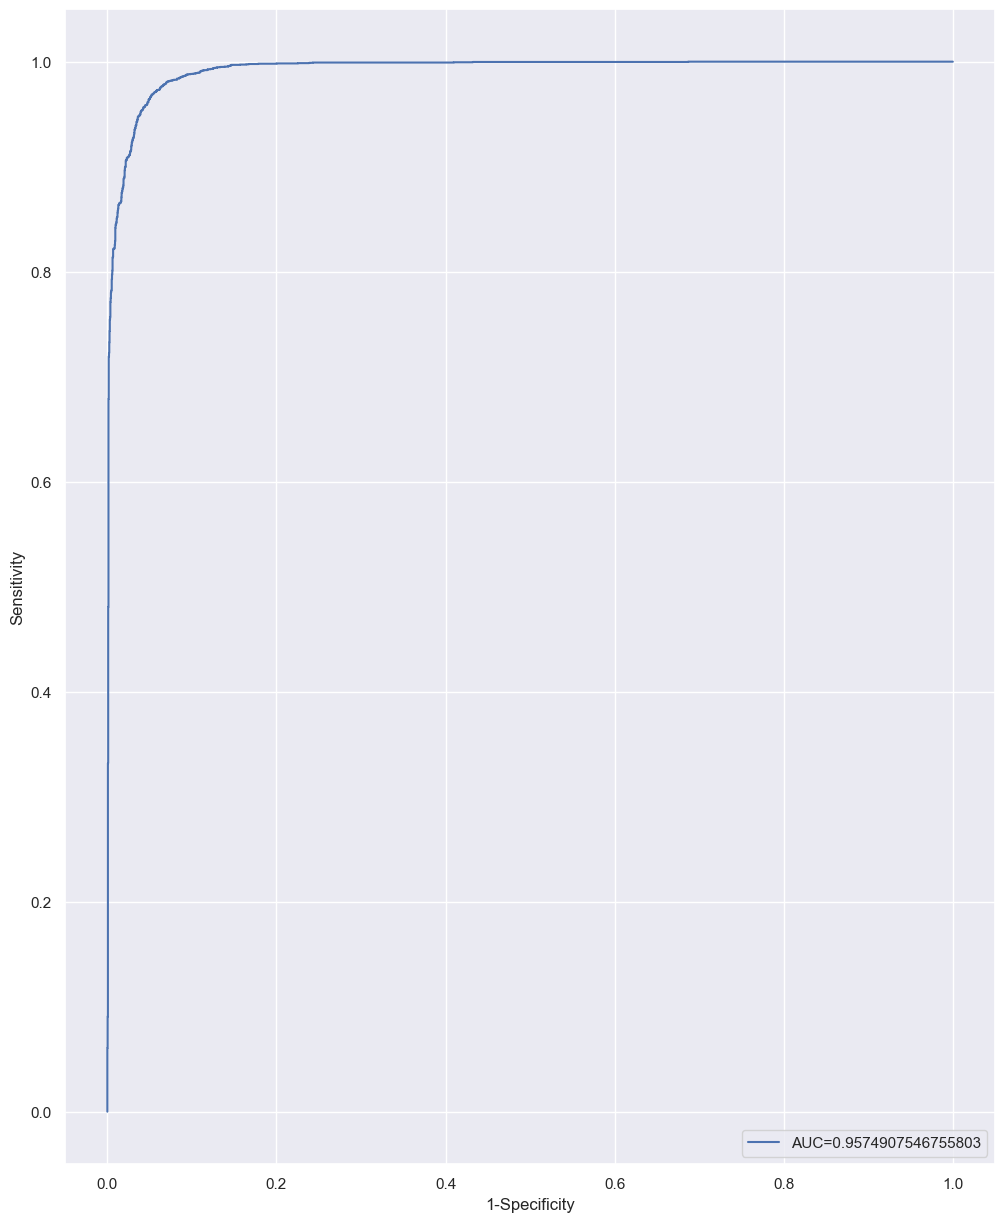

In [116]:
fpr, tpr, _ = roc_curve(y_test,  prob_1)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(cb_roc_auc))
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.legend(loc=4)
plt.show()
